In [1]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple, Counter;
import numpy as np;
import theano
np.random.seed(1234)

scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)
import keras

scriptsDir = os.environ.get("DEEPLIFT_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable DEEPLIFT_DIR");
sys.path.insert(0,scriptsDir)

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
#import deepLIFT stuff
import deepLIFTutils
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/kerasBasedBackprop");
from deepLIFTonGPU import ScoreTypes, Activations_enum, OutLayerInfo, getScoreFunc

Using gpu device 4: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5004)
Using Theano backend.
/users/avanti/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
import vgg16_keras 
reload(vgg16_keras)
from vgg16_keras import *
import h5py
reload(deepLIFTutils)
path_to_weights_file = '/srv/scratch/annashch/cs231n_project/vgg16_weights_dropout_regularization_augmenteddataTintContrast.stupidsgd.hdf5'
keras_model=VGG_16(path_to_weights_file)
#mean_normalise_softmax_weights(keras_model.layers[-2])

In [3]:
keras_model.layers[1]

In [4]:
altered_keras_model = VGG_16(path_to_weights_file)
for (layeridx, layer) in enumerate(altered_keras_model.layers):
    if (layeridx > 1 and (layer.get_config()['name'] == 'Convolution2D' or layer.get_config()['name']=='Dense')):
        weights, biases = layer.get_weights()
        layer.set_weights([weights*(weights>0), biases])

In [5]:
import keras_conversion as kc
reload(kc)
import deeplift_backend as B
reload(B)
import blobs
reload(blobs)
import models
reload(models)
import deeplift_util
reload(deeplift_util)
from blobs import MxtsMode

In [6]:
deeplift_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeepLIFT)
deeplift_contribs_func = deeplift_model.get_target_contribs_func(input_layer_idx=0)
deeplift_multipliers_func = deeplift_model.get_target_multipliers_func(input_layer_idx=0)

Mean-normalising softmax


In [9]:
guided_backprop_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackprop)
guided_backprop_multipliers_func = guided_backprop_model.get_target_multipliers_func(input_layer_idx=0)

Mean-normalising softmax


In [33]:
guided_backprop_altered_model = kc.convert_sequential_model(altered_keras_model, mxts_mode=MxtsMode.GuidedBackprop)
guided_backprop_multipliers_func_altered = guided_backprop_altered_model.get_target_multipliers_func(input_layer_idx=0)

Mean-normalising softmax


In [34]:
gradient_altered_model = kc.convert_sequential_model(altered_keras_model, mxts_mode=MxtsMode.Gradient)
gradient_func_altered = gradient_altered_model.get_target_multipliers_func(input_layer_idx=0)

Mean-normalising softmax


In [ ]:
#gradient_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.Gradient)
#gradient_func = gradient_model.get_target_multipliers_func(input_layer_idx=0)
#grad_times_inp_func = gradient_model.get_target_contribs_func(input_layer_idx=0)

In [ ]:
#deconv_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.DeconvNet)
#deconv_multipliers_func = deconv_model.get_target_multipliers_func(input_layer_idx=0)

In [ ]:
#guided_backprop_deeplift_model = kc.convert_sequential_model(keras_model, mxts_mode=MxtsMode.GuidedBackpropDeepLIFT)
#guided_backprop_deeplift_multipliers_func = guided_backprop_deeplift_model.get_target_multipliers_func(input_layer_idx=0)

In [11]:
import h5py
path_to_data_file = '/srv/scratch/annashch/tiny-imagenet-200/imagenet.transpose.individually.augment.hdf5'#/srv/scratch/annashch/cs231n_project/imagenet.hdf5'
data=h5py.File(path_to_data_file,'r')
xData=data['X_valid']
yData=np.array(data['Y_valid'])
print(len(yData))

10000


In [ ]:
#deeplift_output_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()],
#                                        deeplift_model.get_layers()[-1].get_activation_vars(),
#                                        allow_input_downcast=True)

In [13]:
model_output_func = theano.function([keras_model.layers[0].input], keras_model.layers[-1].get_output(), allow_input_downcast=True)

In [15]:
altered_model_output_func = theano.function([altered_keras_model.layers[0].input], altered_keras_model.layers[-1].get_output(), allow_input_downcast=True)

In [16]:
#get indices of correct predictions
outputs = np.array(deeplift_util.run_function_in_batches(model_output_func, input_data_list=[xData]))
altered_outputs = np.array(deeplift_util.run_function_in_batches(altered_model_output_func, input_data_list=[xData]))
#deeplift_outputs = deeplift_util.run_function_in_batches(deeplift_output_func, input_data_list=[xData])
#deeplift_outputs = np.array(deeplift_outputs)

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000


In [18]:
correct_predictions = [(i,np.max(outputs[i]))
                           for i in xrange(len(yData))
                           if np.argmax(yData[i]) == np.argmax(outputs[i])]
print(len(correct_predictions))

5469


In [19]:
correct_predictions_altered = [(i,np.max(altered_outputs[i]))
                           for i in xrange(len(yData))
                           if np.argmax(yData[i]) == np.argmax(altered_outputs[i])]
print(len(correct_predictions_altered))

50


In [20]:
def rescale_func(values, squish=False):
    values = np.sum(values,axis=0)
    if (squish):
        values = np.log(1+values)
    min_val = 40
    values = (255.0 - min_val)*(values - np.min(values))/(np.max(values)-np.min(values))  + min_val
    return (np.transpose(np.array([values]*3), axes=(1,2,0))).astype(np.uint8)#np.sum(values,axis=0)

class: 117
class: 144
class: 15
class: 168
class: 79


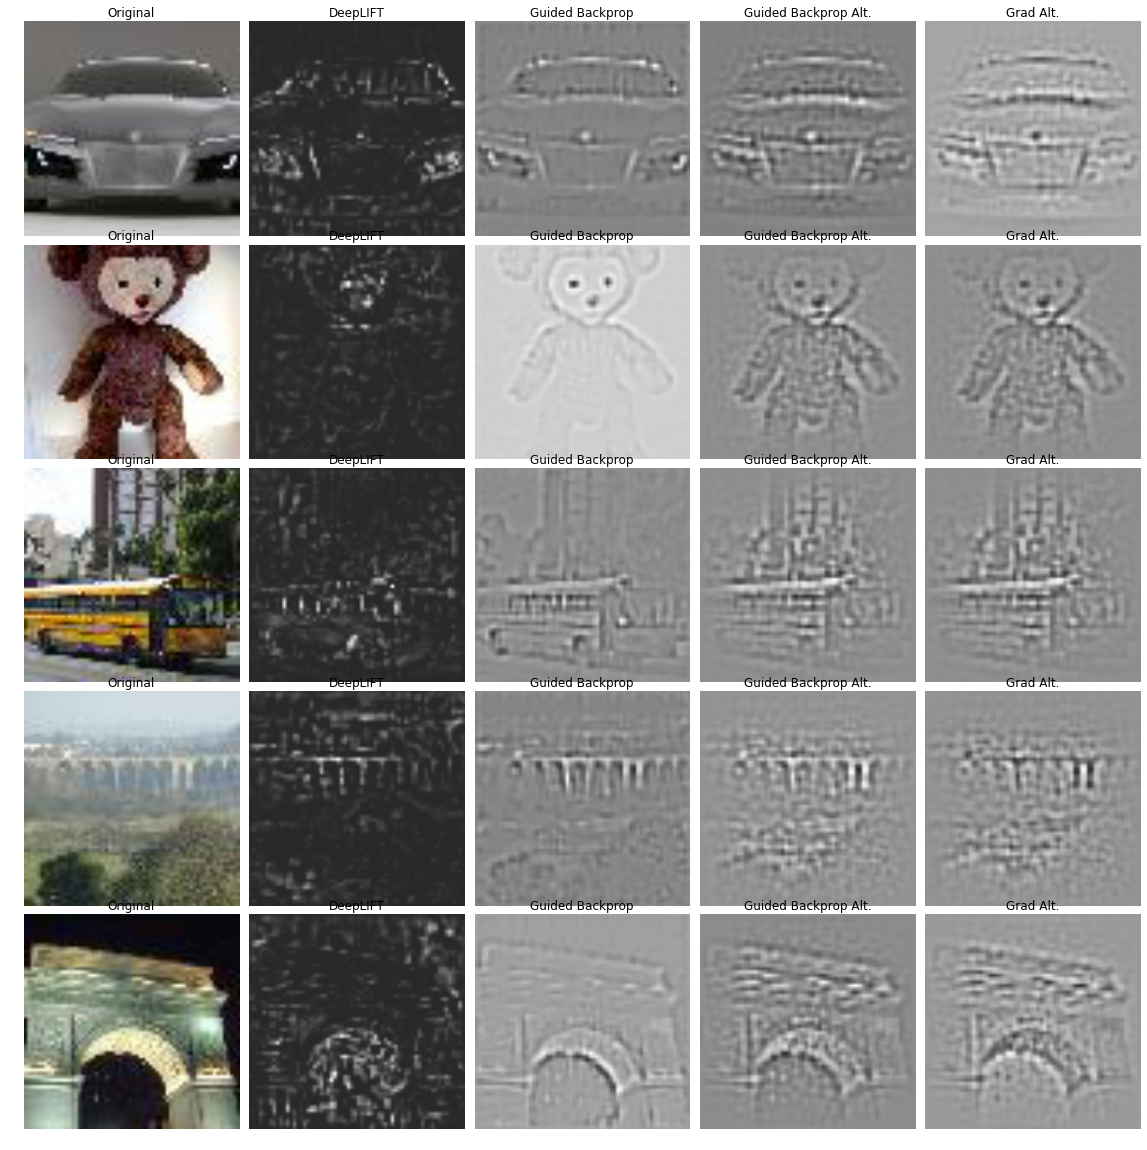

In [35]:
import skimage 
from skimage.io import imread
import matplotlib.pyplot as plt

indices = [18, 5, 8, 24, 17]
#indices = range(20,30)
fig = plt.figure(figsize=(20, 4*len(indices)), facecolor='w')
num_plots=5
for i,idx in enumerate(indices):
    softmax_class = np.argmax(yData[idx])
    print("class:",softmax_class)
    #compute gradients using the model
#    gradients,\
#    grad_times_inp_contribs,\
#    deconv_contribs,\
#    guided_backprop_deeplift_contribs
    guided_backprop_multipliers,\
    guided_backprop_multipliers_altered,\
    gradient_altered,\
    deeplift_contribs\
                        = [contribs_func(task_idx=softmax_class,
                         input_data_list=[[xData[idx]]],
                         batch_size=10,
                         progress_update=None)[0] for
                           contribs_func in [
                                             #gradient_func,
                                             #grad_times_inp_func,
                                             #deconv_multipliers_func,
                                             #guided_backprop_deeplift_multpliers_func
                                             guided_backprop_multipliers_func,
                                             guided_backprop_multipliers_func_altered,
                                             gradient_func_altered,
                                             deeplift_contribs_func,
                                            ]]
    
    plot_print_idx = 1    
    img_original=imread('images/val_'+str(idx)+'.JPEG').astype(np.uint8)
    fig.subplots_adjust(wspace=0.05)
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(right=0)
    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
    plot_print_idx += 1
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img_original)

    plt.subplot(len(indices),num_plots, i*num_plots + plot_print_idx)
    plot_print_idx += 1
    plt.title('DeepLIFT')
    plt.axis('off')
    plt.imshow(rescale_func(deeplift_contribs*(deeplift_contribs>0), squish=True))
    
    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
    plot_print_idx += 1
    plt.title('Guided Backprop')
    plt.axis('off')
    #plt.imshow(rescale_func(guided_backprop_multipliers*(guided_backprop_multipliers>0)))
    plt.imshow(rescale_func(guided_backprop_multipliers))

    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
    plot_print_idx += 1
    plt.title('Guided Backprop Alt.')
    plt.axis('off')
    #plt.imshow(rescale_func(guided_backprop_multipliers_altered*(guided_backprop_multipliers_altered>0)))
    plt.imshow(rescale_func(guided_backprop_multipliers_altered))
    
    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
    plot_print_idx += 1
    plt.title('Grad Alt.')
    plt.axis('off')
    plt.imshow(rescale_func(gradient_altered))
    
#    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
#    plot_print_idx += 1
#    plt.title('Deconv')
#    plt.axis('off')
#    plt.imshow(rescale_func(deconv_contribs*(deconv_contribs>0)))
    
#    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
#    plot_print_idx += 1
#    plt.title('Abs. gradients')
#    plt.axis('off')
#    plt.imshow(rescale_func(np.abs(gradients)))

#    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
#    plot_print_idx += 1
#    plt.title('Taylor')
#    plt.axis('off')
#    plt.imshow(rescale_func(grad_times_inp_contribs*((grad_times_inp_contribs) > 0)))

#    plt.subplot(len(indices), num_plots, i*num_plots + plot_print_idx)
#    plot_print_idx += 1
#    plt.title('Guided Backprop DL')
#    plt.axis('off')
#    plt.imshow(rescale_func(guided_backprop_deeplift_multipliers*(guided_backprop_deeplift_multipliers>0)))
#    #plt.imshow(rescale_func(guided_backprop_deeplift_contribs))
    
    #plt.subplot(len(indices),num_plots, i*num_plots + plot_print_idx)
    #plot_print_idx += 1
    #plt.title('Guided Backprop Taylor')
    #plt.axis('off')
    #gpt = guided_backprop_contribs*xData[idx]
    #plt.imshow(rescale_func(gpt*(gpt>0)))
    
    #plt.subplot(len(indices),num_plots, i*num_plots + plot_print_idx)
    #plot_print_idx += 1
    #plt.title('Guided Backprop DeepLIFT')
    #plt.axis('off')
    #gpdl = guided_backprop_deeplift_contribs*xData[idx]
    #plt.imshow(rescale_func(gpdl*(gpdl>0)))
    
    #plt.subplot(len(indices),num_plots, i*num_plots + plot_print_idx)
    #plot_print_idx += 1
    #plt.title('difference')
    #plt.axis('off')
    #diff = gpdl-gpt
    #plt.imshow(rescale_func(diff))

In [ ]:
correct_prediction_lookup = dict([x for x in correct_predictions])
predictions_output_file = "predictions_summary.txt"
fp.writeToFile(predictions_output_file, "\n".join([str(i)+"\t"+str(deeplift_outputs[i][np.argmax(yData[i])])
                                                         +"\t"+str(i in correct_prediction_lookup)
                                                         +"\t"+str(np.argmax(yData[i]))
                                                         +"\t"+",".join([str(x[0]) for x in sorted(enumerate(deeplift_outputs[i]), key=lambda x:-x[1])[:10]])
                                                       for i in xrange(len(deeplift_outputs))]))

In [ ]:
#get the outputs of the net on the validation set
#reload(deepLIFTutils)
#print(np.shape(data))
#import theano
#import deeplift_util
#
#keras_output_func = theano.function([keras_model.layers[0].input],
#                                     keras_model.layers[-1].get_output(train=False),
#                                     allow_input_downcast=True)
#keras_outputs = deeplift_util.run_function_in_batches(keras_output_func, input_data_list=[data])
#keras_outputs=np.array(keras_outputs)

In [ ]:
#deeplift_output_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()],
#                                        deeplift_model.get_layers()[-1].get_activation_vars(),
#                                        allow_input_downcast=True)
#deeplift_outputs = deeplift_util.run_function_in_batches(deeplift_output_func, input_data_list=[data])
#deeplift_outputs = np.array(deeplift_outputs)

In [ ]:
#np.sum(np.abs(keras_outputs-deeplift_outputs))

In [ ]:
def rescale_func_for_image(values):
    min_val = 0
    values = (255.0 - min_val)*(values - np.min(values))/(np.max(values)-np.min(values))  + min_val
    return np.transpose(np.array([values]*3), axes=(1,2,0))#np.sum(values,axis=0)

In [ ]:
import scipy.misc
def save_image(values, output_dir, suffix, idx):
    values = rescale_func(values).astype(np.uint8)
    name = output_dir+"/val_"+str(idx)+"_"+suffix+".PNG"
    scipy.misc.imsave(name, values)

In [ ]:
def saveSequentialToHDF5
    import h5py;                                                                
    f=h5py.File(options.saveToHDF5,'w')                                         
    dsetNames=['train','valid','test','eval']                                   
    dsetVals=[trainData,validData,testData,evalData]                            
    for i in range(len(dsetNames)):                                             
        if dsetVals[i]==None:                                                   
            continue #case when eval set is not used                            
        dsetName=dsetNames[i]                                                   
        dsetVal=dsetVals[i]                                                     
        dset_Ids=f.create_dataset(dsetName+"Id",data=dsetVal.ids)               
        dset_X=f.create_dataset(dsetName+"X",data=dsetVal.X)                    
        dset_Y=f.create_dataset(dsetName+"Y",data=dsetVal.Y)                    
        dset_LabelNames=f.create_dataset(dsetName+"LabelNames",data=dsetVal.labelNames)
        if dsetVal.featureNames!=None:                                          
            dset_FeatureNames=f.create_dataset(dsetName+"FeatureNames",data=dsetVal.featureNames)
        if dsetVal.weights!=None:                                               
            dset_Weights=f.create_dataset(dsetName+"Weights",data=dsetVal.weights)
    f.flush()                                                                   
    f.close()

In [ ]:
def flush_class(class_to_datapoints, class_to_datapoint_indices, the_class):
    datapoints = class_to_datapoints[the_class]
    indices = class_to_datapoint_indices[the_class]
    class_to_datapoints[the_class] = []
    class_to_datapoint_indices[the_class] = []
    deeplift_contribs = target_contribs_func(task_idx=the_class,
                                             input_data_list=[datapoints],
                                             batch_size=10,
                                             progress_update=None)
    gradients, grad_times_inp_contribs, deeplift_contribs =\
                                                [contribs_func(task_idx=the_class,
                                                         input_data_list=[datapoints],
                                                         batch_size=10,
                                                         progress_update=None) for
                                                           contribs_func in [gradient_func,
                                                                             grad_times_inp_func,
                                                                             deeplift_contribs_func]]
    for j in xrange(len(gradients)):
        simonyan = np.abs(gradients[j])
        simonyan_blackwhite = np.linalg.norm(simonyan, axis=0)
        
        grad_x_inp = (gradients[j]*datapoints[j])*(gradients[j]*datapoints[j])
        grad_x_inp_blackwhite = np.sum(grad_x_inp > 0, axis=0)
        deeplift_contr = deeplift_contribs[j]
        deeplift_contribs_blackwhite = np.sum(deeplift_contr > 0, axis=0)
        
        for (image, image_name) in [(simonyan_blackwhite, "simonyan"),
                                    (grad_x_inp_blackwhite, "grad-x-inp"),
                                    (deeplift_contribs_blackwhite, "liftpad")]:
            save_image(image, output_dir, image_name, indices[j])

In [ ]:
i = 0
read_data_batch_size = 100
class_flush_threshold = 10
output_dir="saliency_maps"
num_classes=200

class_to_datapoints = dict([(x,[]) for x in xrange(num_classes)])
class_to_datapoint_indices = dict([(x,[]) for x in xrange(num_classes)])
while i < len(xData):
    if (i%1000 == 0):
        print("Done ",i)
    xDataInMem = np.array(xData[i:i+read_data_batch_size])
    for j in xrange(len(xDataInMem)):
        the_class = np.argmax(yData[i+j])
        class_to_datapoints[the_class].append(xDataInMem[j])
        class_to_datapoint_indices[the_class].append(i+j)
        if (len(class_to_datapoints[the_class]) > class_flush_threshold):
            flush_class(class_to_datapoints, class_to_datapoint_indices, the_class)
    i += read_data_batch_size

for the_class in xrange(num_classes):
    flush_class(class_to_datapoints, class_to_datapoint_indices, the_class)
    